# Big Data Platform - Final Project

## Covid Tweets Analysis!

### Bhadri Vaidhyanathan

### Objective
<ul>
        <li> Utilize Big Data, PySpark, Parquet, NLP and Google Cloud Platform to analyse tweets related to Covid </li>
        <li> Identify top Twitterers and classify them based on their profile </li>
        <li> Analyse the volume of tweets by location</li>
        <li> Conduct a time series analysis of the Covid Tweets</li>
</ul>


In [2]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import StructType

import findspark
findspark.init()
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark.sql.functions as sql_fun

In [3]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [ ]:
%%time
path = 'gs://msca-bdp-tweets/final_project/'
tweets_df = spark.read.json(path)

# Preprocess

### Data Profile
<ul>
        <li> 100Million Tweets, 617 Gigabytes</li>
        <li> Timeline of tweets: Oct 15,2021 to Jan 25,2022</li>
        <li> Number of columns: 36</li>
        <li> File format: JSON</li>
</ul>

## Filtering dataset

In [ ]:
#reduce to relevant data
from pyspark.sql.functions import col
sample_df = tweets_df.select(col("id"),col("id_str"),col("user"),col("place"),col("text"),col("retweeted_status"), col("extended_tweet"), \
                             col("entities"),col("created_at"), col("coordinates"),col("favorite_count"), \
                             col("quote_count"),col("retweet_count"),col("reply_count"),col("is_quote_status"), \
                             col("retweeted"),col("lang"))

In [ ]:
#extract retweeted status
import pyspark.sql.functions as sql_fun
sample_df = sample_df.withColumn('text',sql_fun.lower(sample_df.text)).withColumn('retweeted_status_text',sql_fun.lower(sample_df.retweeted_status.text))

In [ ]:
#filter1

covid_df = sample_df.filter(sample_df.text.contains('covid')|sample_df.retweeted_status_text.contains('covid'))
covid_df.count()

In [ ]:
## Partition, Parquet and move to personal GCS
covid_df.write.partitionBy("created_at_year", "created_at_mon", "created_at_day") \
        .mode("overwrite") \
        .parquet("gs://msca-bdp-students-bucket/shared_data/bhadri/covid_tweets4_df.parquet")

In [ ]:
#size check in GCS
!gsutil du -sh -a gs://msca-bdp-students-bucket/shared_data/bhadri/covid_tweets_df.parquet/
#move to personal gcs
!gsutil mv "gs://****-bucket/shared_data/****/covid_tweets.parquet" 'gs://***-tweets/covid_tweets.parquet'

#### Tweets or Retweets
Retweets are re-post of other tweets. The original tweet is stored nested within the JSON. The nested information needs to be extracted so the original tweet and author are given the credit. 

In [ ]:
# Creating new columns for user information and extract for retweets

covid_df = covid_df \
            .withColumn('x_user_id',when(covid_df.retweeted == False,col('user.id')).otherwise(col('retweeted_status.user.id'))) \
            .withColumn('x_user_scrname',when(covid_df.retweeted == False,col('user.screen_name')).otherwise(col('retweeted_status.user.screen_name'))) \
            .withColumn('x_user_desc',when(covid_df.retweeted == False,col('user.description')).otherwise(col('retweeted_status.user.description'))) \
            .withColumn('x_user_location',when(covid_df.retweeted == False,col('user.location')).otherwise(col('retweeted_status.user.location')))  \
            .withColumn('x_user_retweet_count',when(covid_df.retweeted == False,col('retweet_count')).otherwise(col('retweeted_status.retweet_count'))) \
            .withColumn('x_user_followers_count',when(covid_df.retweeted == False,col('user.followers_count')).otherwise(col('retweeted_status.user.followers_count'))) \
            .withColumn('x_user_friends_count',when(covid_df.retweeted == False,col('user.friends_count')).otherwise(col('retweeted_status.user.friends_count'))) \
            .withColumn('x_user_verified',when(covid_df.retweeted == False,col('user.verified')).otherwise(col('retweeted_status.user.verified')))

### Top Twitterer by volume of tweets

In [ ]:
#groupby tweets by user
covid_users_pdf = covid_users.groupby("x_user_scrname","x_user_desc","x_user_location","x_user_id","x_user_url") \
                        .agg(   count(covid_users.id).alias('covid_twt_count'), \
                                max(covid_users.x_user_retweet_count).alias('retwt_count'), \
                                max(covid_users.x_user_followers_count).alias('followers_count') \
                            ) \
                        .sort(desc("covid_twt_count"))   

In [23]:
covid_users_pdf = pd.read_csv('user_twt_pdf.csv')
covid_users_pdf.head(3)

C:\Users\vbatt\AppData\Local\Temp\ipykernel_24356\314468927.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_users_pdf = pd.read_csv('user_twt_pdf.csv')


,Unnamed: 0,x_user_name,x_user_scrname,x_user_desc,x_user_location,x_user_id,covid_twt_count,total_tweet_count,avg_retwt_count,followers_count
0,0,"Robert W Malone, MD",RWMaloneMD,"Inventor of mRNA vaccines and RNA as a drug, B...","Madison, VA",3.984488e+07,27532.0,8521.0,1333.550305,473202.0
1,1,Disclose.tv,disclosetv,Observing world events unfold in the grand the...,NaN,1.539249e+07,21596.0,3789.0,2459.135812,736174.0
2,2,Karan Menon,TheKaranMenon,"comedian from jersey, woke tiktok king, featur...","Holmdel, NJ",1.049540e+18,16271.0,223.0,11724.467826,23226.0


In [9]:
covid_users_pdf.shape

(388015, 10)

In [10]:
# #reduce the dataframe to relevant users
# covid_users_pdfx = covid_users_pdf.filter(covid_users_pdf.covid_twt_count > 25).filter(covid_users_pdf.followers_count > 25)
# covid_users_pdfx.shape

(388015, 0)

In [25]:
top_tweeters = covid_users_pdf[covid_users_pdf['covid_twt_count'] >= 10000]
top_tweeters = top_tweeters[['x_user_scrname','covid_twt_count']]
top_tweeters.set_index('x_user_scrname', inplace=True)

''

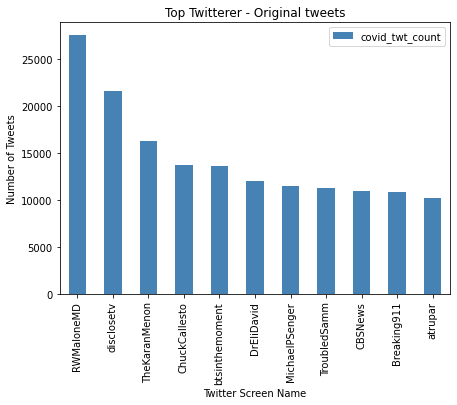

In [26]:
#plot the top Twitterer
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)

top_tweeters.plot.bar(color='steelblue')
plt.title("Top Twitterer - Original tweets")
plt.ylabel("Number of Tweets")
plt.xlabel("Twitter Screen Name")
;

# User Profiling

Profile and classify the users based on 'user description' using NLP techniques.

In [29]:
user_prof_pdf = pd.read_csv('user_prof_full_df.csv')

C:\Users\vbatt\AppData\Local\Temp\ipykernel_24356\3862165279.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  user_prof_pdf = pd.read_csv('user_prof_full_df.csv')


In [30]:
#using description to profie users
user_desc = user_prof_pdf[['x_user_scrname','x_user_desc']]
user_desc.head()

,x_user_scrname,x_user_desc
0,ClayTravis,"http://Outkick.com, @outkick @clayandbuck radi..."
1,PeterSweden7,I'm Peter Imanuelsen | Swedish journalist | Po...
2,thebradfordfile,liberal hypocrisy is a disease
3,PeterSweden7,I'm Peter Imanuelsen | Swedish journalist | Po...
4,earthangeleve,♍︎ ⊙ ♑︎ ☽ 18+ • writer. healer. earth mystic. ...


In [31]:
from gensim.parsing.preprocessing import remove_stopwords

#Clean text and remove stop words from description

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # removes punctuations
    text = re.sub('\w*\d\w*', '', text) #removes numbers
    text = "".join(c for c in text if ord(c)<128)  # remove non ascii characters
    
    cleaned_text = remove_stopwords(text)
           
    return cleaned_text

In [32]:
user_desc['clean_desc'] = user_desc['x_user_desc'].apply(lambda x: clean_text(x))

C:\Users\vbatt\AppData\Local\Temp\ipykernel_24356\292434129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_desc['clean_desc'] = user_desc['x_user_desc'].apply(lambda x: clean_text(x))


In [33]:
user_desc.head()

,x_user_scrname,x_user_desc,clean_desc
0,ClayTravis,"http://Outkick.com, @outkick @clayandbuck radi...",radio pm et tv et author republicans buy sneak...
1,PeterSweden7,I'm Peter Imanuelsen | Swedish journalist | Po...,im peter imanuelsen swedish journalist politic...
2,thebradfordfile,liberal hypocrisy is a disease,liberal hypocrisy disease
3,PeterSweden7,I'm Peter Imanuelsen | Swedish journalist | Po...,im peter imanuelsen swedish journalist politic...
4,earthangeleve,♍︎ ⊙ ♑︎ ☽ 18+ • writer. healer. earth mystic. ...,writer healer earth mystic divine feminine


In [35]:
user_desc.shape

(207142, 3)

### Attempt1: Word Count Analysis
Find the highest frequency words in user descriptions

In [14]:
#create corpus
corpus = ""
for idx,row in user_desc.iterrows():
    corpus+=row.loc['clean_desc']

In [16]:
wordlist = corpus.split()

In [19]:
import collections

word_counter = collections.Counter(wordlist)
for word, count in word_counter.most_common(25):
    print(word, ": ", count)

love :  6518
fan :  5254
im :  5173
dont :  5167
life :  4448
like :  3751
lover :  3459
people :  3408
world :  3098
news :  2987
account :  2966
politics :  2884
music :  2815
health :  2814
follow :  2771
time :  2719
twitter :  2696
mom :  2593
good :  2582
proud :  2577
sheher :  2570
writer :  2570
free :  2454
tweets :  2404
views :  2284


### Attempt 2: ngram analysis

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(ngram_range=(2,2))

# matrix of ngrams
ngrams = c_vec.fit_transform(user_desc.clean_desc)

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram2 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

MemoryError: Unable to allocate 1.33 TiB for an array with shape (207142, 881758) and data type int64

- The CV matrix is too big. Considering that we are only looking to see the top/most frequent terms, we need not process all the ngrams. We can restrict the CV with max_features as below

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(ngram_range=(2,2), max_features = 50)

# matrix of ngrams
ngrams = c_vec.fit_transform(user_desc.clean_desc)

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram2 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [69]:
df_ngram2.head(5)

,frequency,bigram/trigram
0,703,fan account
1,690,husband father
2,633,lives matter
3,523,human rights
4,519,mental health


In [68]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(ngram_range=(3,3), max_features = 50)

# matrix of ngrams
ngrams = c_vec.fit_transform(user_desc['clean_desc'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram3 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

df_ngram3.head(5)

,frequency,bigram/trigram
0,443,black lives matter
1,206,official twitter account
2,192,season ticket holder
3,161,small business owner
4,119,official twitter handle


#### User profiling methodology
(Note: This exercise was done for a class project with limited time window to do the project hence below strategies are far from good)

Based on the highest frequency unigrams, bigrams and trigrams, 4 themes identified among them are News organization or News personnel, an individual (/influencer) and organizations including Government bodies. 

Based on the words in the description the users are bucketed into the 4 user groups as below manually. 


In [70]:
#classify users based on manually curated term list

def user_id(text):
    '''
    Classify text based on presence of key terms
    Detailed Logic:
    Create buckets with key terms and if a the text passed contains any of the key terms, 
    credit 1 point for the concerned bucket. The text gets classified to the bucket with most points"
    '''
    
    id = ""
    news_terms = ['news','breaking','latest','weather','local','reporter']
    health_terms = ['public','health','clinical','medical']
    influencer_terms = ['author','husband','lover','dad','owner','president','writer','editor','wife','mom']
    government_terms =['government','state']
    
    raw_words = text.split(" ")
    
    news,health,individual,government = 0, 0, 0, 0
    news = len([word for word in raw_words if word in news_terms])
    health = len([word for word in raw_words if word in health_terms])
    influencer = len([word for word in raw_words if word in influencer_terms])
    government = len([word for word in raw_words if word in government_terms])
    
    var = {"news":news,"health":health,"individual":individual,"government":government}
    
    val = var.get(max(var))
    
    if  val == 0:
        id = 'Other'
    else:
        id = max(var, key=var.get)
    
    return id

In [72]:
for idx,row in user_desc.iterrows():
    user_desc.loc[idx, 'identity2'] = user_id(row.loc['clean_desc'])

C:\Users\vbatt\AppData\Local\Temp\ipykernel_24356\2180369495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_desc.loc[idx, 'identity2'] = user_id(row.loc['clean_desc'])


In [73]:
user_desc.groupby('identity2').count()

,x_user_scrname,x_user_desc,clean_desc
identity2,,,
Other,202474,176431,202476
government,3,3,3
health,35,35,35
news,4628,4628,4628


## Location Analysis

In [ ]:
loc_df = user_twt_pdf[['x_user_scrname','x_user_location']]
loc_df.head(10)

In [ ]:
import nltk
import spacy
  
# essential entity models downloads
nltk.downloader.download('maxent_ne_chunker')
nltk.downloader.download('words')
nltk.downloader.download('maxent_treebank_pos_tagger')


In [ ]:
!python -m spacy download en
!python -m spacy download en_core_web_sm

In [ ]:
#attempt 1 to identify location


# import locationtagger
# nlp = spacy.load('en_core_web_sm')

# def id_location(text):
#     text = str(text)
#     text = text.lower()
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     place_entity = locationtagger.find_locations(text = text)
#     country = place_entity.countries
#     state = place_entity.regions
#     city = place_entity.cities
#     loc_list = [country,state, city]
#     if len(loc_list) == 0:
#         loc_list = ['unidentified location']
    
#     return loc_list

In [ ]:
# #attempt 2 to locate

# def id_location2(s): 
#     loc_list = []
#     city = ""
#     state= ""
#     country = ""
#     s = s.split()
#     for i in range(len(s)):
#         s[i] = s[i].lower()

#     for place in s:
#         if place in cities:
#             city = place
#         elif place in states:
#             state = place
#         elif place in state_names:
#             state = place
#         elif place in countries:
#             country = place
#         loc_list = [city,state,country]
    
#     return loc_list

In [ ]:
import string
import re

#Clean location text
def clean_loc(text):
    
    text = str(text)
    text = re.sub("[^a-zA-Z\s]+", "",text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub("\d", " ", text)
    
    return text

In [ ]:
for idx,row in loc_df.iterrows():
    clean = clean_loc(row.loc['x_user_location'])
    loc_df.loc[idx, 'clean_loctn'] = clean

In [ ]:
#series splits
loc_splits = loc_df['clean_loctn']
type(loc_splits)


#break into chunks to accomodate insufficient disk space for processing
df0 = loc_splits[0:50000]
df1 = loc_splits[50001:100000]
df2 = loc_splits[100001:150000]
df3 = loc_splits[150001:200000]
df4 = loc_splits[200001:258190]

In [ ]:
# Attempt 3 - nGram Analysis

from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(ngram_range=(2,2))

# matrix of ngrams
ngrams = c_vec.fit_transform(df4)

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df4_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'uni/bigram'})

In [ ]:
#merge dfs
df_loc_final = df_loc_final.set_index('uni/bigram').add(df4_bigram.set_index('uni/bigram'), fill_value=0).reset_index()

In [ ]:
df_loc_final = df_loc_final.sort_values('frequency', ascending=False)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)


df_loc_chart = df_loc_final.head(15).rename(columns={"uni/bigram": "Location"}).set_index('Location')
df_loc_chart.plot.bar(color='brown')
plt.title("Tweet Frequency by Location (Top15)")
plt.ylabel("Frequency")
;

In [ ]:
df_loc_final.to_csv('gs://msca-bdp-test-1203/location_df_analysis.csv')

In [ ]:
# loc_df.to_csv('gs://msca-bdp-test-1203/location_df.csv')

# Time Analysis

In [ ]:
covid_df = spark.read.parquet("gs://msca-bdp-test-1203/covid_tweets4_df.parquet/")

In [ ]:
covid_df.count()

In [ ]:
time_df = covid_df.groupby('created_at_year','created_at_mon','created_at_day','retweeted') \
                    .agg(count(covid_df.id).alias('t_count')) \
                    .sort('created_at_year','created_at_mon','created_at_day','retweeted')

In [ ]:
time_df.show()

In [ ]:
time_df.toPandas().to_csv('gs://msca-bdp-test-1203/time_df.csv')

In [ ]:
full_time_pdf = pd.read_csv('gs://msca-bdp-test-1203/full_time_df.csv')
full_time_pdf.head()

In [ ]:
full_time_pdf['dateInt']=full_time_pdf['created_at_year'].astype(str) + full_time_pdf['created_at_mon'].astype(str).str.zfill(2)+ full_time_pdf['created_at_day'].astype(str).str.zfill(2)
full_time_pdf['Date'] = pd.to_datetime(full_time_pdf['dateInt'], format='%Y%m%d')

In [ ]:
full_time_pdf.drop(['Unnamed: 0','dateInt','created_at_day','created_at_mon','created_at_year'],axis='columns',inplace=True)


In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))

plt.title('Tweet and Retweet Timeline')
plt.ylabel('Number of Tweets /Retweets')
plt.grid(True)

sns.lineplot(data=full_time_pdf, x='Date', y='t_count', hue='retweeted')